# Explore additional metadata info

Provides code for loading in additional metadata files. You can use this as a starting point to explore, analyze, visualize other measurements in the dataset. 

Check out the files for additional information about the column values.

### Setup drive

Run the following cell to mount your Drive onto Colab. Go to the given URL and once you login and copy and paste the authorization code, you should see "drive" pop up in the files tab on the left.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Click the little triangle next to "drive" and navigate to the "AI4All Chest X-Ray Project" folder. Hover over the folder and click the 3 dots that appear on the right. Select "copy path" and replace `PASTE PATH HERE` with the path to your folder.

In [3]:
cd "/content/drive/My Drive/AI4All Project/AI4All Chest X-Ray Project"

/content/drive/My Drive/AI4All Project/AI4All Chest X-Ray Project


### Import necessary libraries

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn import metrics, linear_model, svm

### Setup paths

In [6]:
# setup paths
path_to_dataset = os.path.join('data')
path_to_docs = os.path.join('docs')

### Load metadata

In [7]:
# load training data metadata
metadata = pd.read_csv(os.path.join(path_to_dataset, 'metadata_train.csv'))

# load additional metadata
cohen_severity = pd.read_csv(os.path.join(path_to_docs, 'cohen_severity_scores.csv'), skiprows=5)
cohen_predictions = pd.read_csv(os.path.join(path_to_docs, 'covid_predictions.csv'))

In [17]:
df_merged = pd.merge(cohen_predictions, cohen_severity, how='inner', on='filename')
df_merged.columns

Index(['index', 'patientid', 'offset', 'sex', 'age', 'finding', 'survival',
       'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 28',
       'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
       'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
       'Lung Opacity', 'Enlarged Cardiomediastinum', 'labels',
       'geographic_mean', 'opacity_mean'],
      dtype='object')

In [19]:
observation_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
       'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
       'Lung Opacity', 'Enlarged Cardiomediastinum']

### Plot data

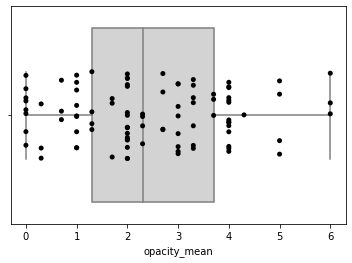

In [18]:
sns.boxplot(cohen_severity.opacity_mean, color='lightgray')
sns.stripplot(cohen_severity.opacity_mean, color='black', jitter=0.2)

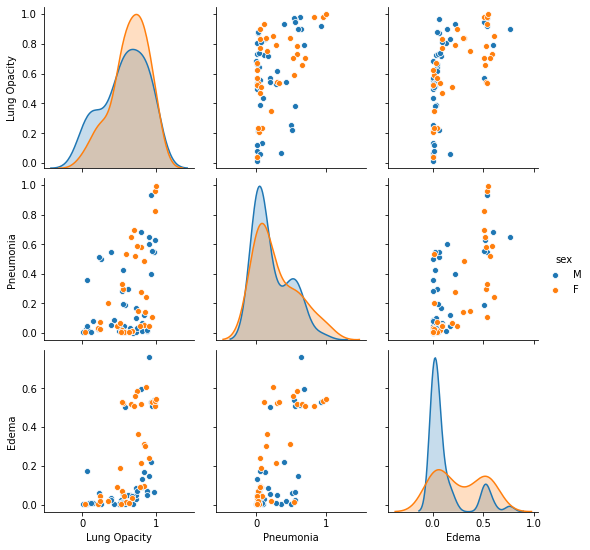

In [26]:
observation_labels_subset = ['Lung Opacity', 'Pneumonia', 'Edema']
sns.pairplot(df_merged, vars=observation_labels_subset, hue='sex')

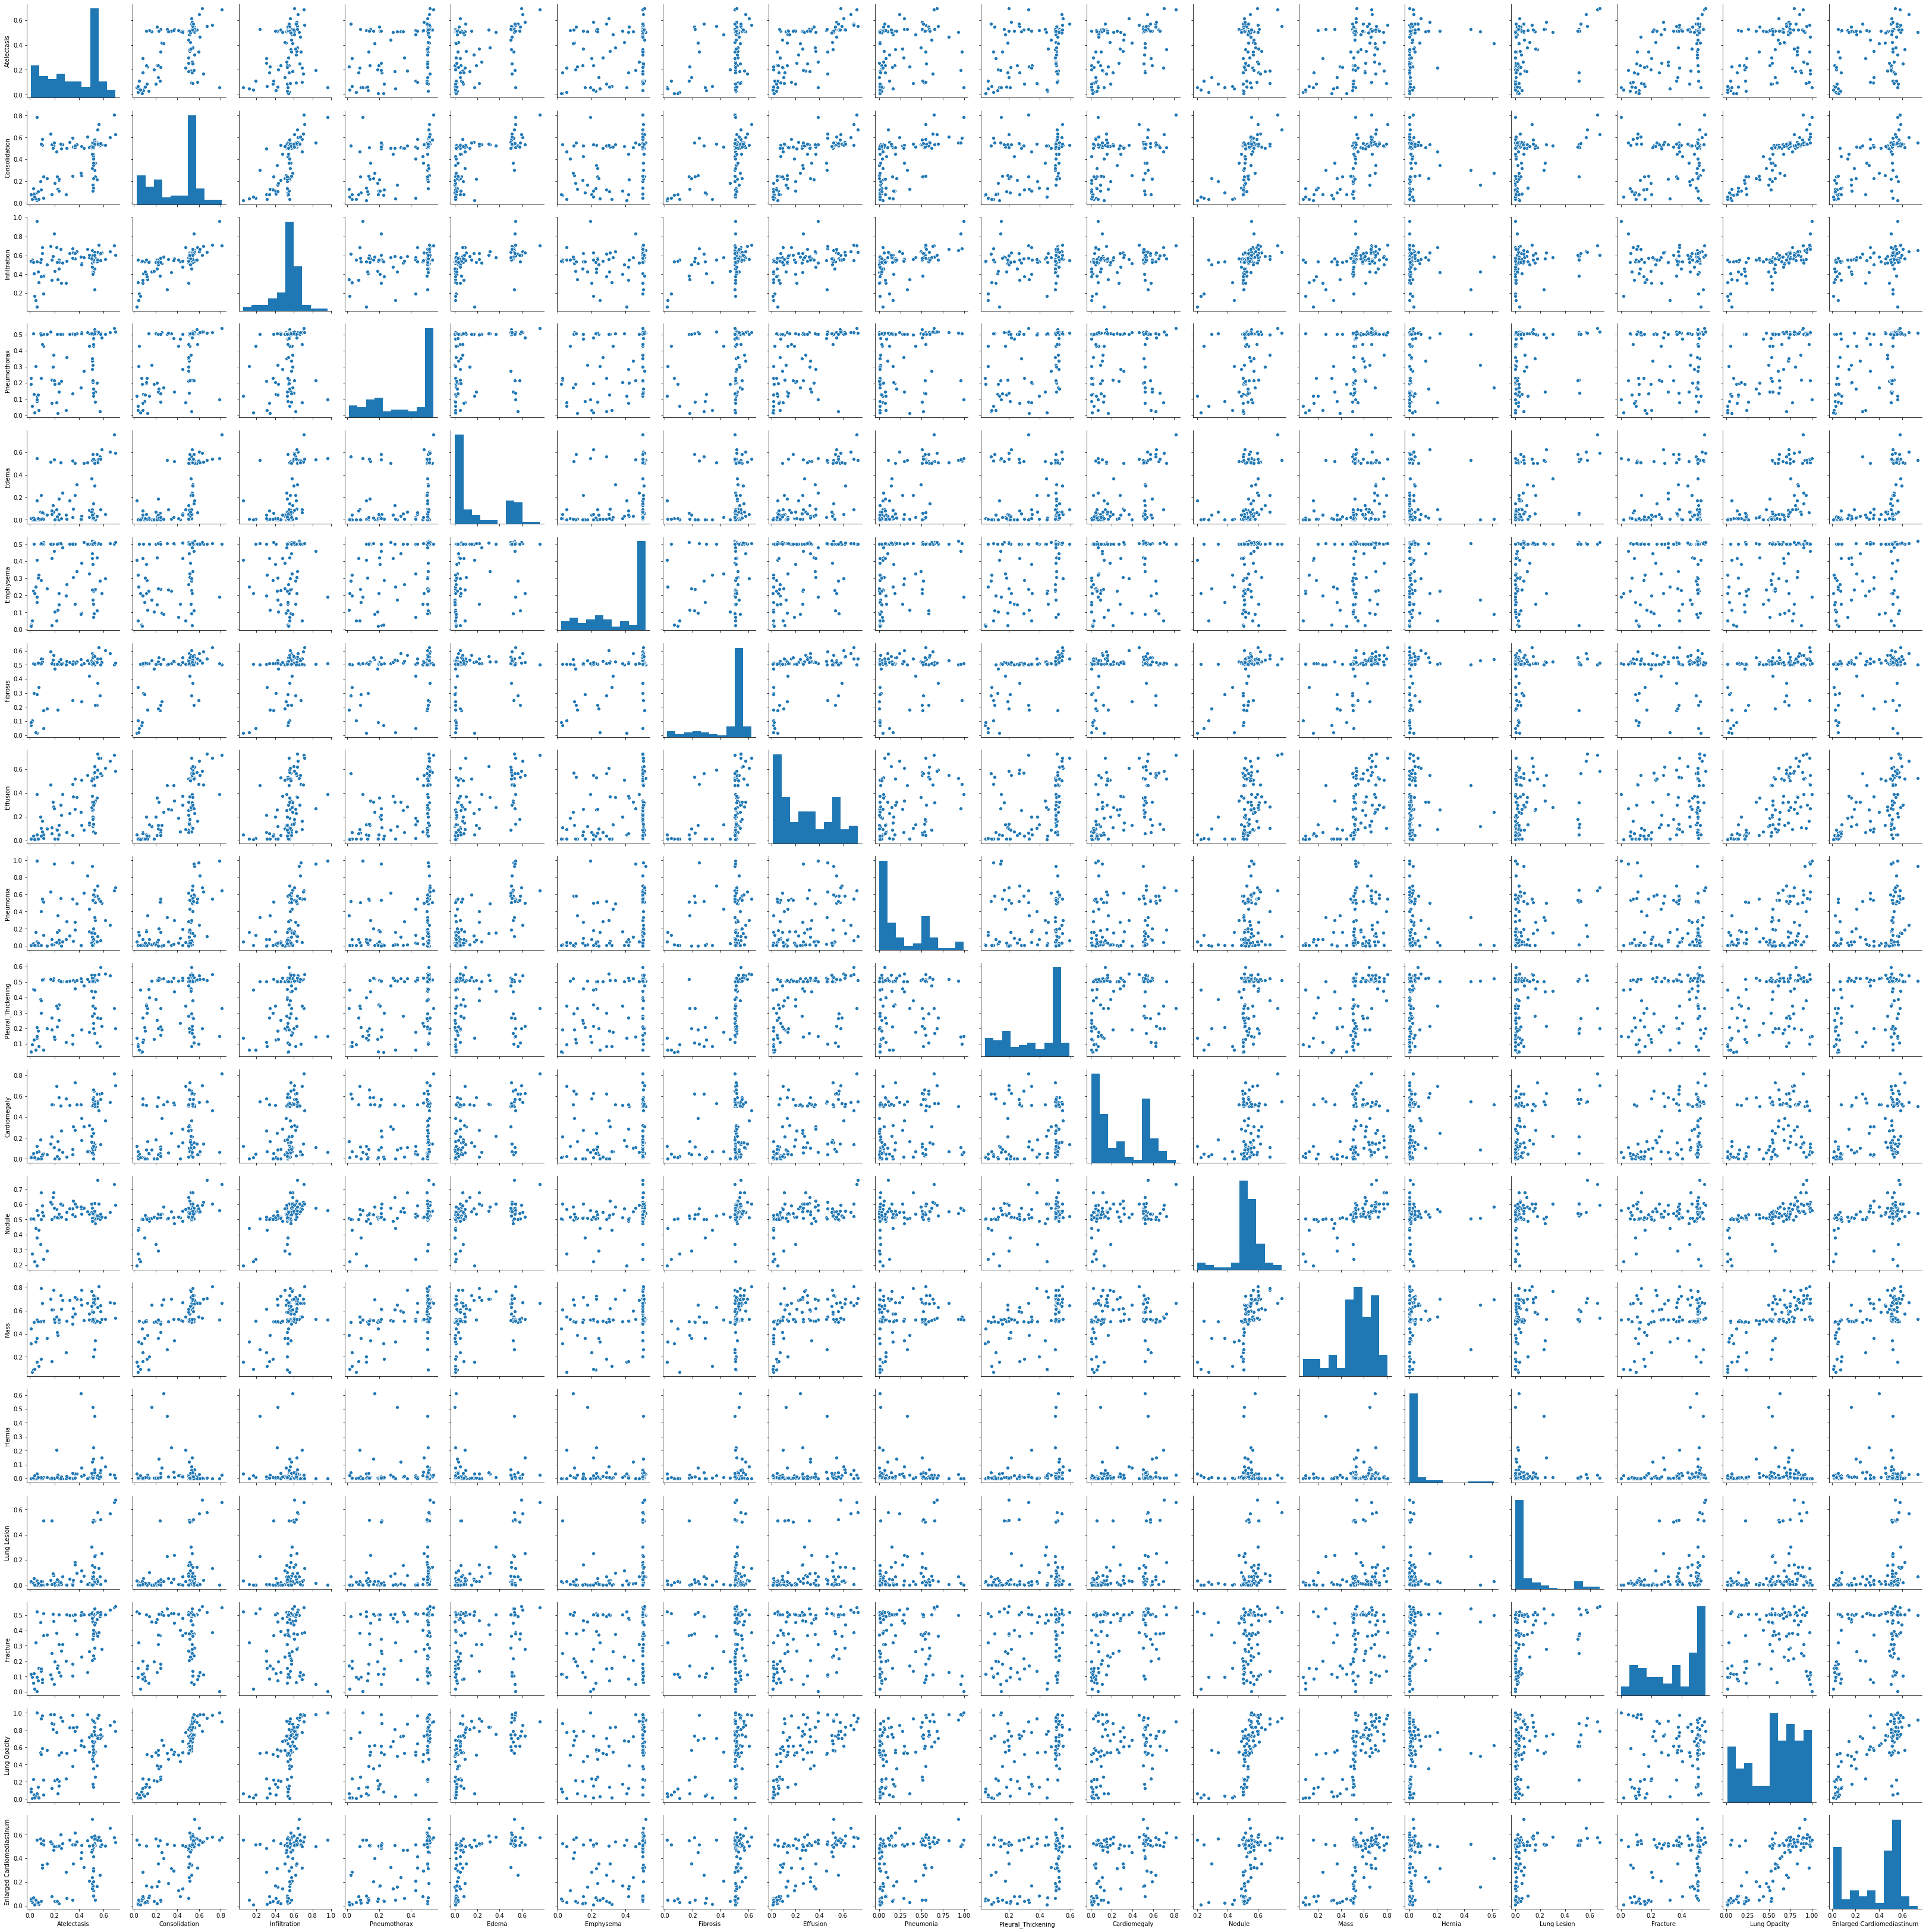

In [ ]:
sns.pairplot(df_merged[observation_labels])

### Train ML models

**Linear regression**

In [21]:
# value to predict
y = df_merged.opacity_mean
# features
X = df_merged[observation_labels]

# fit model
model_reg = linear_model.LinearRegression()
model_reg.fit(X, y)

# predict with model
y_pred = model_reg.predict(X)

# evaluate predictions
mse = metrics.mean_squared_error(y, y_pred)
print(f'MSE = {mse}')

MSE = 0.6445095298597011


Text(0, 0.5, 'Predicted opacity mean')

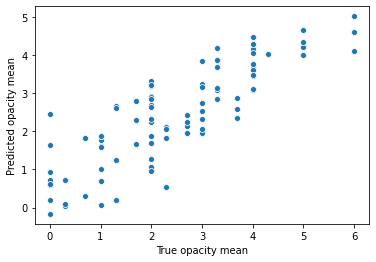

In [23]:
sns.scatterplot(y, y_pred)
plt.xlabel('True opacity mean')
plt.ylabel('Predicted opacity mean')

**SVM**

In [41]:
model_svm = svm.LinearSVC()

# train model
y = cohen_predictions.finding
X = cohen_predictions[observation_labels]
model_svm.fit(X, y)
y_pred = model_svm.predict(X)

# accuracy
metrics.accuracy_score(y, y_pred)

0.7180327868852459

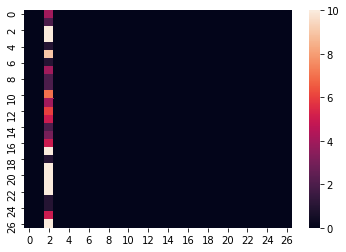

In [43]:
# show confusion matrix

confuse_mat = metrics.confusion_matrix(y, y_pred)
sns.heatmap(confuse_mat, vmax=10)

In [31]:
cohen_predictions.finding.value_counts()

COVID-19                               438
todo                                    22
Pneumocystis                            19
SARS                                    16
No Finding                              14
Streptococcus                           13
COVID-19, ARDS                          12
Pneumonia                               11
Cryptogenic Organizing Pneumonia         9
Klebsiella                               7
Lipoid                                   6
Lobar Pneumonia                          5
Varicella                                5
Mycoplasma Bacterial Pneumonia           5
Legionella                               4
ARDS                                     4
E.Coli                                   4
Multilobar Pneumonia                     3
Influenza                                2
Bacterial                                2
Eosinophilic Pneumonia                   2
Lymphocytic Interstitial Pneumonia       2
Unknown                                  1
Desquamativ

The first attempt didn't do so well since most of the findings are Covid cases. Try again with balanced classes.

In [32]:
# take classes that have a good number of data points
non_covid_findings = ['Pneumocystis', 'SARS', 'No Finding']
cohen_predictions_noncovid_subset = cohen_predictions[cohen_predictions.finding.isin(non_covid_findings)]

# subsample covid cases
cohen_predictions_covid = cohen_predictions[cohen_predictions.finding == 'COVID-19']
cohen_predictions_covid_subset = cohen_predictions_covid.sample(n=20)

cohen_predictions_subset = pd.concat([cohen_predictions_noncovid_subset,cohen_predictions_covid_subset], axis=0)
 

In [36]:
# train model
model_svm = svm.LinearSVC()

y = cohen_predictions_subset.finding
X = cohen_predictions_subset[observation_labels]
model_svm.fit(X, y)
y_pred = model_svm.predict(X)

# accuracy
metrics.accuracy_score(y, y_pred)

0.7536231884057971

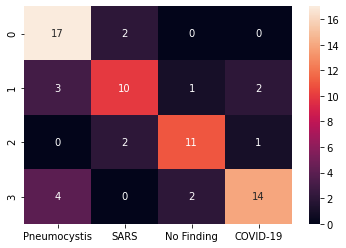

In [38]:
# confusion matrix
labels = ['Pneumocystis', 'SARS', 'No Finding', 'COVID-19']
confuse_mat = metrics.confusion_matrix(y, y_pred, labels=labels)
sns.heatmap(confuse_mat, annot=True, xticklabels=labels)